# Exercise 3: wavefield extrapolation and migration
Contents:
 - Wavefield extrapolation
 - Zero-offset migration
 - Prestack migration
 - Wavefield extrapolation

For a constant-velocity medium, we can extrapolate a wavefield at depth $z$ to depth $z+\Delta z$ via a simple phase shift in the $f-k$ domain:

$ u(\omega,k,z + \Delta z) = u(\omega,k,z)\exp[\imath\Delta z\sqrt(\omega^2/v^2 - k^2)]$

To illustrate this, we generate a source wavefield in the $t-x$ domain and extrapolate it. First, let's define an impulsive source.

In [1]:
using PyPlot

# f-k domain transform function fktran

In [2]:
function fktran(a,t,x,mode)
    """
    f-k transform for real-values input.

    use:
        b, f, k = fktran(a,t,x,mode)

    input:
        a - matrix in t-x domain (nt x nx)
        t - time vector
        x - x vector
        mode - 1:forward, -1:inverse
    """

    nt = length(t)
    nx = length(x)

    dt = t[2]-t[1]
    dx = x[2] - x[1]

    xmax = x[end] - x[1]
    tmax = t[end] - t[1]


    f = 0:1/tmax:.5/dt
    k = -.5/dx:1/xmax:.5/dx

    nf = length(f)
    if mode == 1
        b = fft(a, 1)
        b = b[1:nf, :]
        b = ifft(b, 2)
        b = circshift(b,[0 ceil(Int, nx/2)-1]);
    elseif mode == -1
        b = circshift(a,[0 floor(Int, nx/2)+1]);
        b = fft(b, 2)
        b = ifft(b, 1)
        b = real(b)
    else
        error("unknown mode")
    end
    return b, f, k
end

fktran (generic function with 1 method)

In [3]:
# time coordinate in seconds as column vector
t = 0:.004:1;

# spatial coordinate in meters as row vector
x = 0:10:1000;

# generate 2D grid:
tt = [ti for ti in t, xi in x];
xx = [xi for ti in t, xi in x];

In [4]:
# Source wavefield is impulsive source at t=0.1 and x=500,
source = (tt-.1).*exp.(-1e-3*(xx.-500).^2 .- 1e3*(tt-.1).^2);

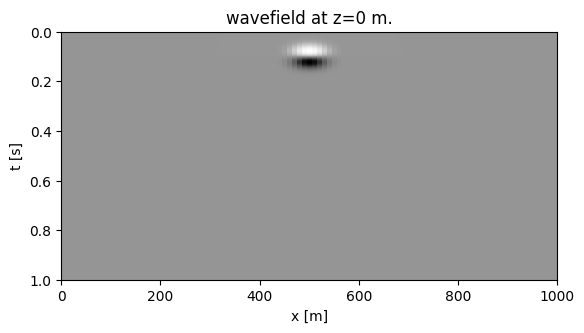

PyObject Text(0.5,1,'wavefield at z=0 m.')

In [5]:
# plot it
imshow(source, cmap="Greys", extent=[x[1], x[end], t[end], t[1]], aspect=500)
xlabel("x [m]")
ylabel("t [s]")
title("wavefield at z=0 m.")

In [6]:
# now, transform it to the f-k domain using fktran
source_fk, f, k = fktran(source,t,x,1);

Next, we define the extrapolation factor and plot it.

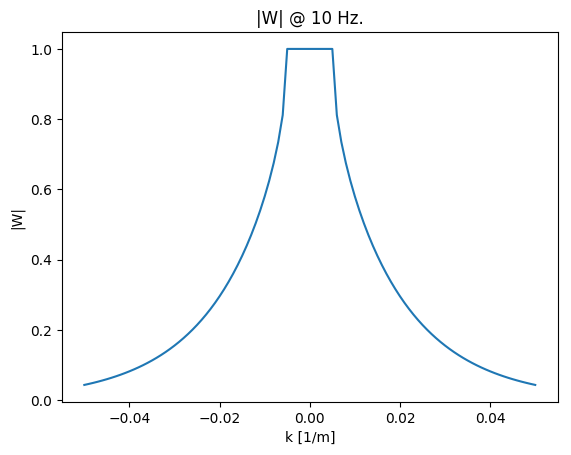

In [7]:
# generate a grid for f,k
ff = [fi for fi in f, ki in k]
kk = [ki for fi in f, ki in k]

# the extrapolation factor for a velocity v is defined as follows 
# (note the factor \(2 pi\) to go from frequency to wavenumber)
v  = 2000
dz = 10
kz = 2*pi*sqrt.(complex.((ff./v).^2 - kk.^2))

W  = exp.(dz*im.*kz)

# now plot absolute value for 10 Hz
plot(k,abs.(W[ff.==10]))
xlabel("k [1/m]");ylabel("|W|");title("|W| @ 10 Hz.");

The region where the extrapolation factor is smaller than one is called the evanescent region. Waves this these wavenumbers will be damped. We have to be carefull with the sign of \(k_z\) in the exponentional factor and make sure that the absolute value is always smaller than one.

The wavefield at z = 500 m looks like

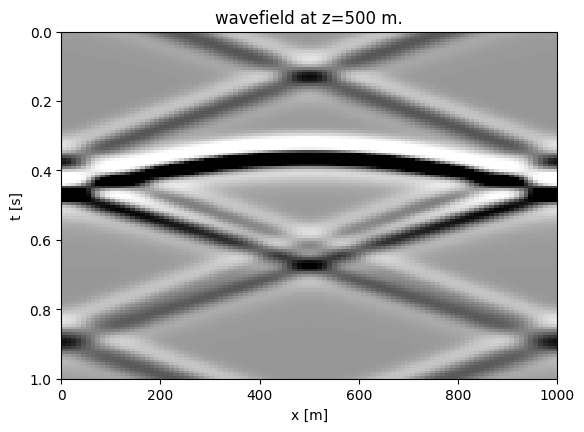

PyObject Text(0.5,1,'wavefield at z=500 m.')

In [8]:
# fix sign of kz
kz = -real(kz)+im*abs.(imag(kz));
W  = exp.(500*im.*kz);

# extrapolate and transform back to t-x
source_extrap, _, _ = fktran(W.*source_fk,t,x,-1);

#plot
imshow(real(source_extrap), cmap="Greys", vmin=-.1e-2, vmax=.1e-2, extent=[x[1], x[end], t[end], t[1]], aspect=700)
xlabel("x [m]")
ylabel("t [s]")
title("wavefield at z=500 m.")

# Questions
 - What happens if the imaginary part of kz has the wrong sign? try it.
 - same for the real part.
 - What does the extrapolator look like in the t-x domain?
 - How can you extraplotate the wavefield in the t-x domain directly using the extrapolator in the t-x domain?

# Zero-offset migration
In this part of the exercise we look at zero-offset migration. This type of migration is based on the
"exploding-reflector" concept. Zero-offset migration can be done by exptrapolating the zero-offset data with half-velocity
and taking the image to be slice of the wavefield at $t=0$ for each depth step: $I(z,x) = u(z,x,t=0)$

The function wave_extrap.m takes in a wavefield u and the correspoding time/space vectors t,x, a velocity v,
a depth step dz and a propagation direction dir and extrapolates the input wavefield.



Load the zero-offset `data data1_zero.segy` (in Dropbox) and define the source, receiver and time coordinates. The units of the source and receiver coordinates are in meters for this file. The data looks like this

In [9]:
using SeisIO

# Dowload and adapt path
shot = segy_read("data_zo.segy")

shot_data = Float32.(shot.data)

sx = get_header(shot, "SourceX", scale=false)
dt = get_header(shot, "dt")[1]/1e6
nt = get_header(shot, "ns")[1]
T = 0:dt:(nt -1)*dt

0.0:0.004:1.0

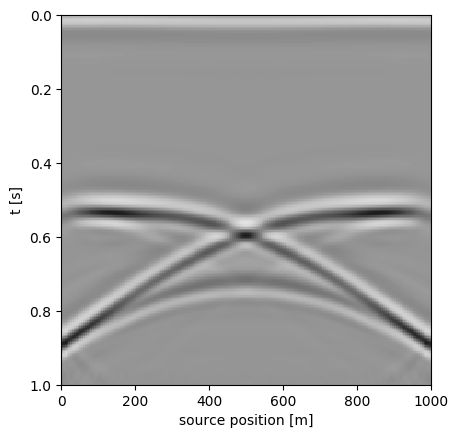

PyObject Text(24,0.5,'t [s]')

In [10]:
imshow(shot_data, vmin=-.1, vmax=.1, cmap="Greys", extent=[sx[1], sx[end], T[end], T[1]], aspect=1000)
xlabel("source position [m]")
ylabel("t [s]")

Use the function `wave_extrap` to migrate the zero offset section. A reasonable depth axis is z = 0:5:1000. Use the source position as lateral position x. The correct velocity is v0 = 2000 km/s (but, remember this is zero-offset migration so adapt the velocity accordingly!). A zero-offset migration can done as follows:

In [11]:
function wave_extrap(u,t,x,v,dz,dir)
# wavefield extrapolation by phase shift
#
# use:
#   v = wave_extrap(u,t,x,v,dz,dir)
#
# input:
#   u   - wavefield as matrix of size length(t) x length(x)
#   t   - time coordinates in seconds as column vector
#   x   - space coordinates in meters as row vector
#   v   - velocity in m/s (scalar)   
#   dz  - depth step in meters
#   dir - 1: forward in time, -1 backward in time
#
# output:
#   v   - extrapolated wavefield
#

    # fk transform of the wavefield
    spec, f, k = fktran(u, t, x, 1)

    # define grid and kz
    ff = [fi for fi in f, ki in k]
    kk = [ki for fi in f, ki in k]
    kz = 2*pi*sqrt.(complex((ff/v).^2-kk.^2))

    # set sign of real part of kz
    kz = -sign.(dir)*real(kz)+im*abs.(imag(kz))

    # apply phase shift
    spec = exp.(im*abs.(dz).*kz).*spec

    # inverse fk transform
    v, _, _  = fktran(spec, f, k, -1)

    # take real part of wavefield
    v = real(v)
    
    return v
end

wave_extrap (generic function with 1 method)

In [12]:
# depth axis
z  = 0:5:1000
dz = 5

# velocity
v = 2000

# migrate for correct velocity
migcorr = zeros(length(z),length(sx))
for k = 1:length(z)
    tmp = wave_extrap(shot_data, T, sx, v./2, z[k], -1)
    migcorr[k, :] =  tmp[1, :]
end


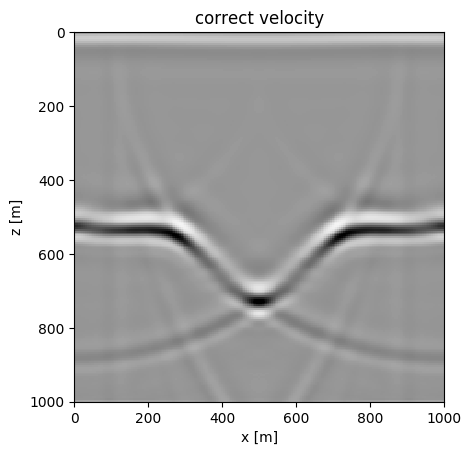

PyObject Text(0.5,1,'correct velocity')

In [13]:
# plot it
imshow(migcorr, cmap="Greys", vmin=-.1, vmax=.1, extent=[sx[1], sx[end], z[end], z[1]], aspect=1)
xlabel("x [m]")
ylabel("z [m]")
title("correct velocity")

# Questions

 - Compare the migrated result to the zero-offset section. What do you notice? For easier comparison, you might want to transform the time axis into depth using the correct velocity.
 - Do a zero-offset migration for too low and too high velocities. What do you notice?
 - Repeat the same exercise for data2_zo.su. What do you notice here?

# Prestack migration
We can also create an image by extrapolating the source wavefields and the data and correlating them at different depth levels.

Read the data `data_ex3.segy` (in Dropbox)

In [14]:
block = segy_read("data_ex3.segy")

sx = get_header(block, "SourceX", scale=false)
rx = get_header(block, "GroupX", scale=false)
dt = get_header(block, "dt")[1]/1e6
nt = get_header(block, "ns")[1]
T = 0:dt:(nt -1)*dt

# unique src/rec locations

xs = unique(sx)
xr = unique(rx);

We extrapolate both source and receiver wavefields for one shot using `wave_extrap` (see comments in wave_extrap for documenation) and plot them side-by-side:

In [15]:
# velocity
v = 2000;

# t-x grid
tt = [ti for ti in T, xi in xr];
xx = [xi for ti in T, xi in xr];

# choose shot 6
is = 6

# source wavefield at z=0
source = (tt-.1).*exp.(-1e-3*(xx-xs[is]).^2 - 1e3*(tt-.1).^2);

# receiver wavefield is data for corresponding shot
receiver = Float32.(block.data[:, sx.==xs[is]]);

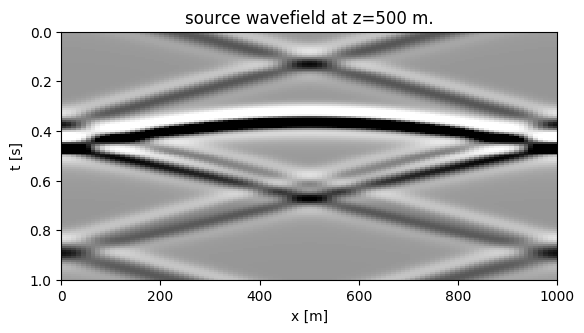

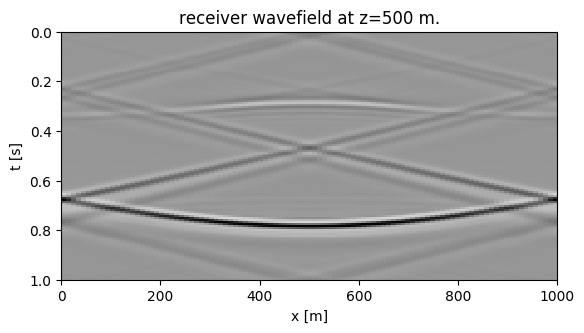

PyObject Text(0.5,1,'receiver wavefield at z=500 m.')

In [16]:
imshow(wave_extrap(source,t,xr,v,500,1), cmap="Greys", vmin=-.001, vmax=.001, extent=[xr[1], xr[end], T[end], T[1]], aspect=500)
xlabel("x [m]")
ylabel("t [s]")
title("source wavefield at z=500 m.")

figure()
imshow(wave_extrap(receiver,t,xr,v,500,-1), cmap="Greys", vmin=-1, vmax=1, extent=[xr[1], xr[end], T[end], T[1]], aspect=500)
xlabel("x [m]")
ylabel("t [s]")
title("receiver wavefield at z=500 m.")

# Question

 - Extrapolate both source and receiver wavefields to differents depths. What do you notice?

An image of the reflector can be constructed by correlating the two wavefields at zero time-lag (basically summing over time)

In [17]:
# velocity
v = 2e3

# depth
dz = 10
z  = 0:dz:1000

# initialize image
image = zeros(length(z),length(xr))

# loop
for iz = 1:length(z)
    shoti       = wave_extrap(source, T, xr, v, z[iz], 1)
    reci        = wave_extrap(receiver, T, xr, v, z[iz], -1)
    image[iz,:] = sum(shoti.*reci, 1)
end


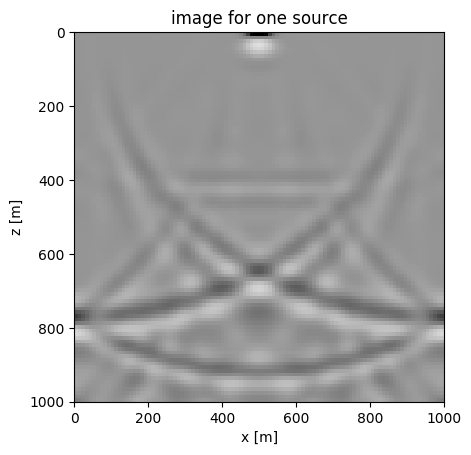

PyObject Text(0.5,1,'image for one source')

In [18]:
figure()
imshow(image, cmap="Greys", vmin=-1e-2, vmax=1e-2, extent=[xr[1], xr[end], z[end], z[1]], aspect=1)
xlabel("x [m]")
ylabel("z [m]")
title("image for one source")

# Questions

 - Use the template `mig_extrap` below and implement migration of multiple shots based on the above outlined algorithm by filling in the gaps. You can call wave_extrap as subroutine. Use mig_extrap.m for the following exercises.
 - Migrate a single shot for velocities that are too low and too high (say 10 percent). What do you see?
 - Repeat this for all sources and sum the images for all sources, again also for too low/high velocity. What do you see?
 - Describe how you would adapt the migration algorithm for a velocity that varies with depth.


In [19]:
function mig_extrap(data, t, xr, xs, z, v)
#
# shot-receiver migration for constant velocity by wavefield extrapolation.
#
# use:
#   image = mig_extrap(data,t,xr,xs,v)
#
# input:
#   data  - data cube of size length(t) x length(xr) x length(xs) 
#   t     - time coordinate in seconds as column vector
#   xr    - receiver coordinate in meters as row vector
#   xs    - source coordinate in meters as row vector
#   z     - depth coordinate in meters as column vector
#   v     - velocity in m/s (scalar)
#
# output:
#   image - image as matrix of size length(z) x length(xr)

    # initialize image
    image = zeros(length(z),length(xr));

    # depth step 
    dz = z[2] - z[1]

    # t-x grid
    tt = [ti for ti in t, xi in xr]
    xx = [xi for ti in t, xi in xr]

    # loop over shots
    for is = 1:length(xs)
        # construct impulsive source at source location
        source   = (tt-.1).*exp.(-1e-3*(xx-xs[is]).^2 - 1e3*(tt-.1).^2);

        # select data beloning to source is
        receiver = 

        # loop over depth levels
        for iz = 1:length(z)
            # use wave_extrap to advance both wavefields one depthlevel
            srci    = 
            reci    = 

            # update image
            image[iz,:] = image[iz,:] + 
        end
        # end loop over depth levels
    end
    # end loop over shots
    
    return image
end

LoadError: [91msyntax: unexpected "end"[39m